This notebook demonstrates LD (linkage disequilibrium) calculations.

The following screenshot shows a screenshot of Haploview program, which illustrates how LD matrix might look like.

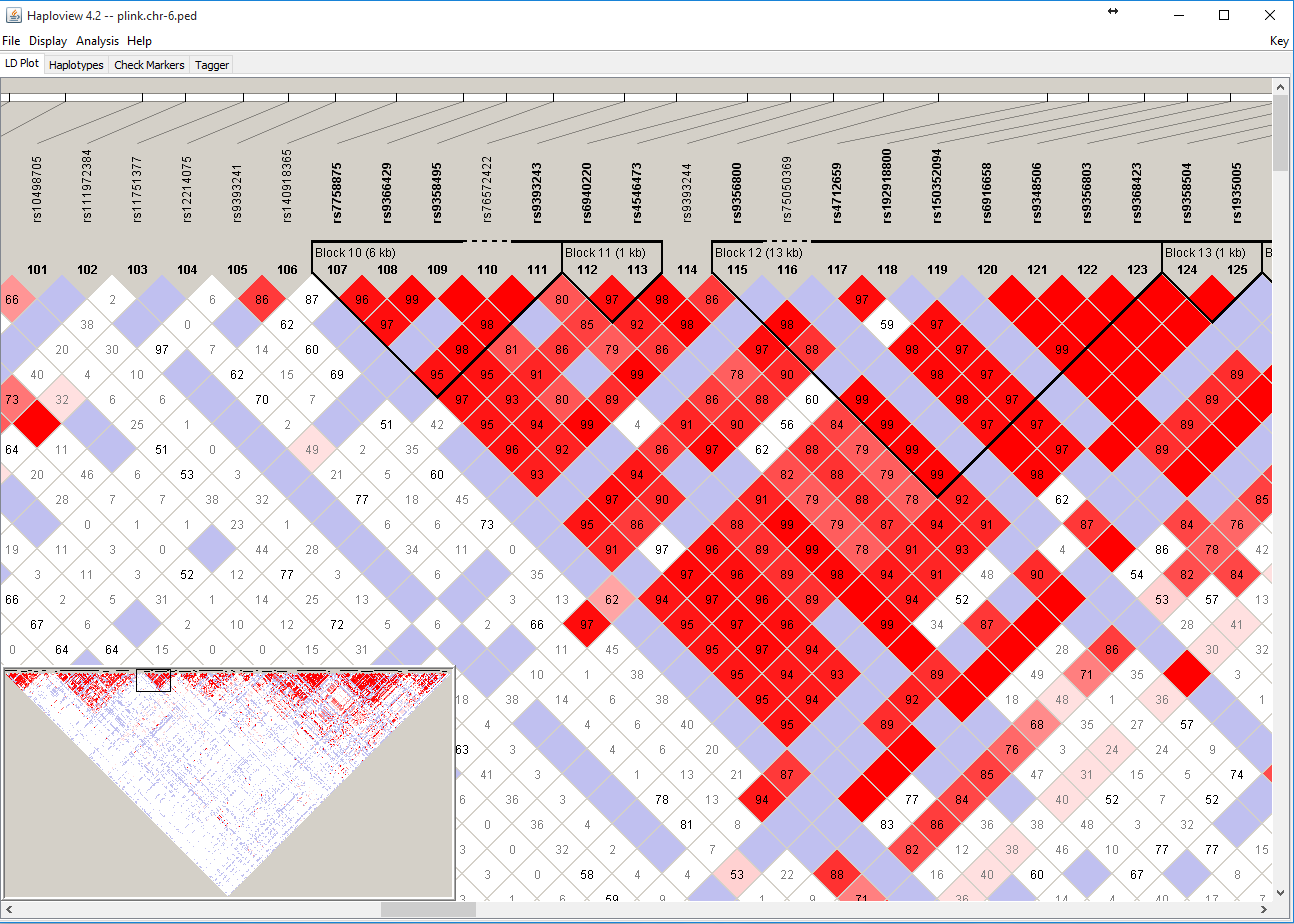

In [1]:
from IPython.display import Image
Image(filename='Haploview_screenshot.PNG') 

To understand how Haploview calculates the values in the LD matrix let's first load some example data that will allow us to calculate LD (r^2 and D') for two specific SNPs.
The input file is in the "Linkage format" of Haploview 4.2, as described [here](
http://www.broadinstitute.org/science/programs/medical-and-population-genetics/haploview/input-file-formats-0).

In [1]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv('just2.chr-6.ped', sep='\t', header=None, 
                 names=['FamilyId', 'Id', 'FatherId', 'MotherId', 'Sex', 'Affection',
                        'A1', 'A2', 'B1', 'B2'],
                 index_col=1)
df = df[['A1', 'A2', 'B1', 'B2']]  # prune all irrelevant columns
df[:6]

,A1,A2,B1,B2
Id,,,,
id1,A,G,G,A
id2,A,G,G,A
id3,A,A,A,A
id4,A,A,G,A
id5,A,A,A,A
id6,G,G,G,G


The table above shows a subset of 6 individuals, and their genotype at two locus - A and B. Each locus is represented at two homologous chromosomes (locus A represent SNP rs1928160, and locus B represents SNP rs62404665, both located at chromosome 6). Hence in total there are 4 columns in the table.

Note that many [SNP genotyping](https://en.wikipedia.org/wiki/SNP_genotyping) technologies does not resolve haplotype. This means that, for example, for individual ``id1`` we don't know whether both of his chromosome 6 has ``AG`` haplotype, or whether one is ``AA`` and another is ``GG``.

Let's now calculate a 3x3 Punnett square of the frequencies. Even though we denote heterozigote cells (the middle row and column) by ``AG``, they contain the combined frequency for ``AG`` and ``GA`` haplotypes.

In [3]:
df['LocusA'] = df['A1'] + df['A2']
df['LocusB'] = df['B2'] + df['B1']
df['count'] = 1
freq = df[['count', 'LocusA', 'LocusB']].groupby(['LocusA', 'LocusB']).sum().unstack(level=1)['count']
freq.fillna(0, inplace=True)
freq

LocusB,AA,AG,GG
LocusA,,,
AA,83.0,2.0,0.0
AG,50.0,133.0,0.0
GG,7.0,45.0,59.0


Our next goal is to infer haplotype frequencies. This process is known as [Haplotype_resolution](https://en.wikipedia.org/wiki/Haplotype#Haplotype_resolution), as described in the following papers:
* [W. G. Hill - Estimation of linkage disequilibrium in randomly mating populations](http://www.nature.com/hdy/journal/v33/n2/abs/hdy197489a.html)
* [Gaunt at all - Cubic exact solutions for the estimation of pairwise haplotype frequencies](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-428)

The four haplotypes in our example are `[AA, AG, GA, GG]`, where the first letter represent ``LocusA``, and the second letter ``LocusB``. All cells except for the double-heterozigote cell (``AG / AG``) contribute to well-defined haplotypes -- for example, the number ``83`` contributes ``166`` times ``AA`` haplotypes, cell ``50`` --- ``50`` times  ``AA`` and  ``50`` times ``GA`` haplotypes, etc. Let's for the moment ignore the middle cell and count the number of known haplotypes.

In [4]:
# Calculate incomplete distributions of haplotype frequencies
# (ignore double-heterozigote AG/AG cell)

AA = 'AA'; AG = 'AG'; GG = 'GG';
X_AA = 2 * freq[AA][AA] + freq[AA][AG] + freq[AG][AA]  # 2 * 83 + 50 + 2
X_AG = 2 * freq[GG][AA] + freq[AG][AA] + freq[GG][AG]  # 2 * 0  + 2  + 0
X_GA = 2 * freq[AA][GG] + freq[AA][AG] + freq[AG][GG]  # 2 * 7  + 50 + 45
X_GG = 2 * freq[GG][GG] + freq[AG][GG] + freq[GG][AG]  # 2 * 59 + 45 + 0

N = float(X_AA + X_AG + X_GA + X_GG + 2 * freq[AG][AG])

p_A = (X_AA + X_AG + freq[AG][AG]) / N
p_B = (X_AA + X_GA + freq[AG][AG]) / N

print 'Known haplotype frequencies: {}'.format([X_AA, X_AG, X_GA, X_GG])
print 'Unknown haplotype frequency: {}'.format(2 * freq[AG][AG])
print 'Total number of chromosomes: {}'.format(N)
print 'Allele frequencies of A at locusA: {}'.format(p_A)
print 'Allele frequencies of A at locusB: {}'.format(p_B)

Known haplotype frequencies: [218.0, 2.0, 109.0, 163.0]
Unknown haplotype frequency: 266.0
Total number of chromosomes: 758.0
Allele frequencies of A at locusA: 0.465699208443
Allele frequencies of A at locusB: 0.606860158311


How, setup an arbitrary initial approximation for haplotype frequencies, and
iterate recurrent expresion for haplotype frequencies until convergence.
This procedure assume that both ``locusA`` and and ``locusB`` are at Hardy-Weinberg Equilibrium.

In [5]:
f_AA = f_AG = f_GA = f_GG = 0.25

print 'AA\t\tAG\t\tGA\t\tGG'
for i in xrange(1, 10):
    r = (f_AA * f_GG) / (f_AA * f_GG + f_AG * f_GA)
    (f_AA, f_AG, f_GA, f_GG) = ((X_AA + r     * freq[AG][AG]) / N,
                                (X_GA + (1-r) * freq[AG][AG]) / N,
                                (X_AG + (1-r) * freq[AG][AG]) / N,
                                (X_GG + r     * freq[AG][AG]) / N )
    print f_AA, f_AG, f_GA, f_GG
    

AA		AG		GA		GG
0.375329815303 0.231530343008 0.0903693931398 0.302770448549
0.43577787115 0.171082287162 0.0299213372937 0.363218504395
0.457563857546 0.149296300765 0.00813535089695 0.385004490792
0.461859234469 0.145000923843 0.00383997397454 0.389299867714
0.46251900355 0.144341154761 0.00318020489322 0.389959636795
0.462615261027 0.144244897284 0.00308394741585 0.390055894273
0.462629193039 0.144230965273 0.00307001540477 0.390069826284
0.462631207167 0.144228951144 0.00306800127619 0.390071840412
0.462631498297 0.144228660014 0.00306771014594 0.390072131543


How given that we have haplotype frequencies it should be really easy to calculate ``D'`` and ``r^2``.

In [6]:
D = f_AA - p_A * p_B
D_max = min(p_A * p_B , (1 - p_A) * (1 - p_B)) if (D < 0) else min(p_A * (1 - p_B), p_B * (1 - p_A))

print 'D = {}'.format(D / D_max)
print 'r^2 = {}'.format(np.square(D) / (p_A * p_B * (1 - p_A) * (1 - p_B)))

D = 0.983244331309
r^2 = 0.545884819361


Note that these result are consistent with plink, even though plink uses more advanced algorithm from *Cubic exact solutions for the estimation of pairwise haplotype frequencies* paper.
```
E:\sandbox>plink --bfile chr6 --ld rs1928160 rs62404665
PLINK v1.90b3.38 64-bit (7 Jun 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile chr6
  --ld rs1928160 rs62404665

32693 MB RAM detected; reserving 16346 MB for main workspace.
1925995 variants loaded from .bim file.
379 people (379 males, 0 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 379 founders and 0 nonfounders present.
Calculating allele frequencies... done.
1925995 variants and 379 people pass filters and QC.
Note: No phenotypes present.

--ld rs1928160 rs62404665:

   R-sq = 0.545885       D' = 0.983245

   Haplotype     Frequency    Expectation under LE
   ---------     ---------    --------------------
          AG      0.003068                0.183085
          GG      0.390072                0.210055
          AA      0.462632                0.282614
          GA      0.144229                0.324246

   In phase alleles are AA/GG
```

For future reference, the Haploview program is taken from
[here](https://www.broadinstitute.org/scientific-community/science/programs/medical-and-population-genetics/haploview/haploview), and plink2 can be downloaded from https://www.cog-genomics.org/plink2/.
The input data was prepared with the following commands

```
plink --bfile chr6 --recode HV --snps-only no-DI
      --from-kb 22000 --to-kb 22500 --chr 6 --allele1234 --maf  --bp-space 1000
      
plink --bfile chr6 --recode HV --snps-only no-DI --snps rs1928160,rs62404665 --chr 6  --out just2
```
You may also check the online page that estimates haplotype frequencies: http://www.genes.org.uk/software/cubex/

**Exercises**

1. Validate that locusA and locusB are at HWE.

Now, the results from plink are somewhat different if you run 
```
plink --bfile chr6_22000_22500 --r2 --ld-snp rs1928160 --ld-window-kb 1000 --ld-window 99999 --ld-window-r2 0
```
which outputs ``plink.ld`` with the following entry for ``rs1928160, rs62404665``.
```
 CHR_A         BP_A                SNP_A  CHR_B         BP_B                SNP_B           R2 
     6     22006676            rs1928160      6     22008449           rs62404665     0.559873 
```
The value reported here is a square of Pearson correlation coefficien, correlated on dosages.

In [11]:
from scipy.stats import pearsonr
df['A.dosage'] = (df['A1'] == 'A').astype(int) + (df['A2'] == 'A').astype(int)
df['B.dosage'] = (df['B1'] == 'A').astype(int) + (df['B2'] == 'A').astype(int)
(r, pval) = pearsonr(df['A.dosage'], df['B.dosage'])
print r*r

0.559873178816
